In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import re
import matplotlib

from nltk.stem.snowball import SnowballStemmer
import nltk
import gensim
import spacy

import matplotlib.cm as cm

stemmer = SnowballStemmer("english")
nlp = spacy.load("en_core_web_sm")

### Data Cleaning Functions

In [14]:
def unique(x):
    d={}
    for i in x:
        d[i]=d.get(i,0)+1
    return sorted(d.items(),key=lambda x: -x[1])

def find_kol(data,rank):
    user=[]
    for i in data:
        user.append(i['user_id'])
    user_d={}
    for i in user:
        user_d[i]=user_d.get(i,0)+1
    user_frequency=unique(user)
    kol_id=[i[0] for i in user_frequency[:rank]]
    kol_name=[]
    for j in kol_id:
        for i in data:
            if i['user_id']==j:
                kol_name.append(i['username'])
                break
    return kol_name

def unique_time(data):
    time=[]
    for i in data:
        time.append(i['timestamp'][:10])
    return sorted(unique(time),key=lambda x: x[0])

def exforeign(data):
    eng_data=[]
    for i in data:
        pos=i['text_html'].find('>')
        if 'lang="en"' in i['text_html'][:pos]:
            eng_data.append(i)
    return eng_data

def duplicate(data):
    result=[]
    text=[]
    for i in data:
        if i['text'] not in text:
            result.append(i)
            text.append(i['text'])
    return result

def remove_link(data):
    for x,i in enumerate(data):
        if '/' in i['text']:
            result = re.sub(r"(https|http)\S+", "", i['text'])
            #result=re.sub(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','',i['text'])
            result = re.sub(r"\S+.com\S+", "", result)
            data[x]['text']=result
    return data

def remove_sign(data):
    for x,i in enumerate(data):
        # hash tag
        result=re.sub(r'#\S+', '', i['text'])
        # user mention
        #result=re.sub(r'#\S+', '', result)
        # emoji
        result=re.sub(r'[^\x00-\x7F]+', '', result)
        # html tags
        result=re.sub(r'<.*?>', '', result)
        # punctuation
        from string import punctuation as punc
        result=re.sub('[{}]'.format(punc), '', result)
        # extra spaces
        result=re.sub(r'\s+', ' ', result)
        data[x]['text']=result
    return data

def total_clean(indata):
    data=exforeign(indata)
    data=duplicate(data)
    data=remove_link(data)
    data=remove_sign(data)
    return data
        
def toword(data,stem=False,stop=True):
    result=[]
    t=nltk.tokenize.TweetTokenizer(strip_handles=True, reduce_len=True)
    f=(stemmer.stem) if (stem) else (lambda x: x)
    STOPWORDS= gensim.parsing.preprocessing.STOPWORDS if stop else set()
    for x,i in enumerate(data):
        temp=[f(j).lower() for j in t.tokenize(i['text'])\
              if j.isalnum() and (f(j).lower() not in STOPWORDS)]
        result.append(temp)
    return result#stemmer.stem(j)

### Sentiment Words Lexicon

In [3]:
def get_words(url):
    import requests
    words = requests.get(url).content.decode('latin-1')
    word_list = words.split('\n')
    index = 0
    while index < len(word_list):
        word = word_list[index]
        if ';' in word or not word:
            word_list.pop(index)
        else:
            index+=1
    return word_list
p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
pos=set(get_words(p_url))
neg=set(get_words(n_url))
opinion=pos.union(neg)

### Model

In [62]:
# create a list of globally defined positive and negative words to identify sentiment
# sentiment score based on the laxicon neg, pos words
def debug2(sentence, pos=pos, neg=neg):
    '''
    input: dictionary and sentence
    function: appends dictionary with new features if the feature
              did not exist previously,then updates sentiment to
              each of the new or existing features
    output: updated dictionary
    '''
    sent_dict = dict()
    noun_mark=[]
    sentence = nlp(sentence)
    opinion_words = neg.union(pos)
    op=0
    for token in sentence:
        # check if the word is an opinion word, then assign sentiment
        if token.text in opinion_words:
            op=1
            sentiment = 1 if token.text in pos else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            if (token.dep_ == "advmod"):
                continue
            else:
                for child in token.children:
                    # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
                        sentiment *= 2
                    # check for negation words and flip the sign of sentiment
                    if child.dep_ == "neg":
                        sentiment *= -1
                if (token.pos_) == "VERB":
                    for child in token.children:
                        # if verb, check if there's a direct object
                        if (child.dep_ == "dobj") or (child.dep_=="nsubj"):                        
                            sent_dict[child] = sentiment
                            if child not in noun_mark: noun_mark.append(child)
                            # check for conjugates (a AND b), then add both to dictionary
                            subchildren = []
                            conj = 0
                            for subchild in child.children:
                                if (subchild.text == "and"):
                                    conj=1
                                if (conj == 1) and (subchild.text != "and"):
                                    subchildren.append(subchild)
                                    conj = 0
                            for subchild in subchildren:
                                sent_dict[subchild] = sentiment
                                if subchild not in noun_mark: noun_mark.append(subchild)

                if (token.dep_ == "amod"):
                    #print('a')
                    sent_dict[token.head] = sentiment
                    noun_mark.append(token.head)
                
                    subchildren = []
                    conj = 0
                    for subchild in token.head.children:
                        if (subchild.text == "and"):
                            conj=1
                        if (conj == 1) and (subchild.text != "and"):
                            subchildren.append(subchild)
                            conj = 0
                    for subchild in subchildren:
                        sent_dict[subchild] = sentiment
                        if subchild not in noun_mark: noun_mark.append(subchild)
                
                for child in token.head.children:
                    if (child.pos_ == "NOUN") and (child.text not in sent_dict) \
                    and (child.dep_ not in ["npadvmod"]):
                        sent_dict[child] = sentiment
                        if child not in noun_mark: noun_mark.append(child)
                        #print(token,sent_dict)
                        #print(token.text+':','compund noun',sent_dict)

    temp=[]  
    for noun in set(noun_mark):
        #print(noun,noun_mark,sent_dict)
        #print('1:',temp)
        sentiment = sent_dict[noun]
        if (noun.pos_ == "NOUN" or noun.pos_ == "PROPN") and (noun not in temp):
            temp.append(noun)
            s=noun.text
            current=noun
            state=1
            while current.children and state:
                temp.append(current)
                state=0
                for child in list(current.children)[::-1]:
                    if ((child.pos_ == "NOUN") or (child.pos_ == "PROPN")) and (child.dep_ == "compound"):
                        s = child.text + " " + s
                        current=child
                        temp.append(child)
                        state=1
            del sent_dict[noun]
            sent_dict[s] = sentiment
    #print(sent_dict)
    sent_dict=dict([i for i in sent_dict.items() if type(i[0])==str])
    #print(sent_dict)
    '''
    # check for nouns
    for child in token.head.children:
        noun = ""
        if (child.pos_ == "NOUN") and (child.text not in sent_dict):
            noun = child.text
            # Check for compound nouns
            for subchild in child.children:
                if subchild.dep_ == "compound":
                    noun = subchild.text + " " + noun
            sent_dict[noun] = sentiment
    '''
    if (not sent_dict) and op:
        for token in sentence:
            if token.pos_=="NOUN":
                sent_dict[token.text]=sentiment
    #print(sent_dict)
    return sent_dict

### Model Running

In [66]:
'''
# run only one time
data=[]
import time
begin=time.time()
for i in range(2015,2021):
    for j in range(1,13):
        print(i,j)
        result=[]
        try:
            data=json.load(open('.\wm\Wealth_Management{}-{:02d}.json'.format(i,j)))
        except FileNotFoundError:
            break
        temp=[]
        for z in data:
            if z['retweets']>0 or z['likes']>0 or z['is_replied'] or z['is_reply_to'] or z['replies']:
                temp.append(z)
        data1=total_clean(temp)
        
        for x,k in enumerate(data1):
            d=debug2(k['text']).items()
            if d: result.append(list(d))
        with open("C:\\Users\\rfmen\\Desktop\\Competition\\rough\\{}-{:02d}.txt".format(i,j), "w") as file:
            file.write(str(result))
        print(time.time()-begin,':',len(result),len(data))
        begin=time.time()
'''

'\n# run only one time\ndata=[]\nimport time\nbegin=time.time()\nfor i in range(2015,2021):\n    for j in range(1,13):\n        print(i,j)\n        result=[]\n        try:\n            data=json.load(open(\'.\\wm\\Wealth_Management{}-{:02d}.json\'.format(i,j)))\n        except FileNotFoundError:\n            break\n        temp=[]\n        for z in data:\n            if z[\'retweets\']>0 or z[\'likes\']>0 or z[\'is_replied\'] or z[\'is_reply_to\'] or z[\'replies\']:\n                temp.append(z)\n        data1=total_clean(temp)\n        \n        for x,k in enumerate(data1):\n            d=debug2(k[\'text\']).items()\n            if d: result.append(list(d))\n        with open("C:\\Users\\rfmen\\Desktop\\Competition\\rough\\{}-{:02d}.txt".format(i,j), "w") as file:\n            file.write(str(result))\n        print(time.time()-begin,\':\',len(result),len(data))\n        begin=time.time()\n'

# Without removing duplicate

In [67]:
data=[]
for i in range(2015,2021):
    for j in range(1,13):
        try:
            data+=json.load(open('.\wm\Wealth_Management{}-{:02d}.json'.format(i,j)))
        except:
            pass

In [25]:
len(data)

621133

In [ ]:
overall=[]
for i in result:
    temp=analyze(i)
    for j in temp:
        if j[0]=='wealth management':
            overall.append(j[1][0]/j[1][1])
overall1=[]
for i in result:
    temp=analyze(i)
    for j in temp:
        if j[0]=='wealth':
            overall1.append(j[1][0]/j[1][1])
overall2=[]
for i in result:
    temp=analyze(i)
    for j in temp:
        if j[0]=='management':
            overall2.append(j[1][0]/j[1][1])
crisis=[]
for i in result:
    temp=analyze(i)
    state=1
    for j in temp:
        if j[0]=='crisis':
            crisis.append(j[1][0]/j[1][1])
            state=0
    if state: crisis.append(0)
plt.figure(figsize=(10,4))
matplotlib.rcParams['figure.dpi']=100
plt.plot(overall,label='wealth management')
plt.plot(overall1,label='wealth')
plt.plot(overall2,label='management')
plt.legend()
plt.xlabel('Month')
plt.title('Average Polarity')
plt.show()

### Dependency Parsing and POS Tagging Example

In [162]:
example=[]
for j in range(1,7):
    try: #Wealth_Management2017-02.json
        temp=json.load(open('.\wm\Wealth_Management{}-{:02d}.json'.format(2017,j)))
        example+=temp
    except:
        break
example=exforeign(example)
example=duplicate(example)
example=remove_link(example)
example=remove_sign(example)
words=toword(example,stop=False)
texts=[' '.join(i) for i in words]

In [169]:
a=nlp('RT Money 5 new ways your 401k will make you richer by retirement ')
spacy.displacy.render(a, style="dep",jupyter=True, options={'distance': 120})

In [6]:
a=nlp('7 Things Investors Need to Know for Building a Better Path in 2017 ABinsights')
spacy.displacy.render(a, style="dep",jupyter=True, options={'distance': 120})

In [172]:
s=['RT Money 5 new ways your 401k will make you richer by retirement',
   'Why intergenerational wealth transfer could be bad for the industry',
   '7 Things Investors Need to Know for Building a Better Path in 2017 ABinsights',
   'Morgan Stanley said it gave a significant number of wealthmanagement clients incorrect tax information']
for i in s:
    print(i)
    print(debug2(i),'\n')

RT Money 5 new ways your 401k will make you richer by retirement
{'401k': 1} 

Why intergenerational wealth transfer could be bad for the industry
{'wealth transfer': -1} 

7 Things Investors Need to Know for Building a Better Path in 2017 ABinsights
{} 

Morgan Stanley said it gave a significant number of wealthmanagement clients incorrect tax information
{'number': 1, 'tax information': -1} 



# 6/17: Loading Result

In [69]:
# import 
result=[]
for i in range(2015,2021):
    for j in range(1,13):
        try:
            with open("C:\\Users\\rfmen\\Desktop\\Competition\\rough\\{}-{:02d}.txt".format(i,j), "r") as file:
                temp=eval(file.readline())
                result.append(temp)
        except:
            break

In [74]:
def analyze(x):
    result={}
    for i in x:
        d=dict(i)
        for j in d:
            if j not in result:
                result[j]=(d[j],1)
            else:
                result[j]=(result[j][0]+d[j],result[j][1]+1)
    return list(result.items())

In [75]:
a=analyze(result[0])
a

[('way', (2, 2)),
 ('wisdom', (1, 1)),
 ('Farnsley Johnston Wealth Management', (1, 1)),
 ('AmeripriseNews', (1, 1)),
 ('Thanks', (2, 2)),
 ('bank', (2, 2)),
 ('Hollywoods', (2, 2)),
 ('advisors', (0, 2)),
 ('doubledigit AUM growth', (1, 1)),
 ('places', (-1, 1)),
 ('financing', (-1, 1)),
 ('junk', (-1, 1)),
 ('Okotokslawyer', (-1, 1)),
 ('access', (1, 1)),
 ('process', (1, 1)),
 ('proven', (1, 1)),
 ('post', (1, 1)),
 ('explanation', (1, 1)),
 ('work', (2, 2)),
 ('plenty', (1, 1)),
 ('dinner time', (-1, 1)),
 ('US companies', (-1, 1)),
 ('dollar', (-3, 3)),
 ('email', (1, 1)),
 ('questions', (-1, 1)),
 ('momentum', (-1, 1)),
 ('SNB policy shock', (-1, 1)),
 ('worth', (1, 1)),
 ('firm', (3, 2)),
 ('wealth', (16, 18)),
 ('management', (8, 13)),
 ('insurance', (1, 1)),
 ('time', (0, 4)),
 ('expertise', (1, 1)),
 ('Cubas talks', (1, 1)),
 ('Castro', (1, 1)),
 ('returns', (2, 2)),
 ('approach', (1, 1)),
 ('confidence', (1, 1)),
 ('advice', (3, 3)),
 ('quality', (1, 1)),
 ('Debt', (1, 1)),


In [81]:
a=[analyze(i) for i in result]

In [ ]:
sum()

In [83]:
month=[]
for i in range(2015,2021):
    for j in range(1,13):
        if i<2020 or j<=5:
            month.append('{}-{:02d}'.format(i,j))

In [198]:
for i in range(len(month)):
    temp=sorted(analyze(result[i]),key=lambda x: -x[1][1])[:10]
    #word=[i[0]+': '+str(round(i[1][0]/i[1][1],2)) for i in temp]
    word=[i[0] for i in temp]
    print(month[i],'\t',word[2:])

2015-01 	 ['talent', 'wealth management', 'investment risk', 'time', 'person', 'dollar', 'advice', 'wealth management firm']
2015-02 	 ['cost savings', 'wealth management', 'investment risk', 'team', 'firms', 'problem', 'trust', 'benefits']
2015-03 	 ['wealth management', 'investment risk', 'advisors', 'advisor', 'wealth management guide', 'disruption', 'standard', 'risk']
2015-04 	 ['favour', 'wealth management', 'banking', 'support', 'clients', 'group', 'issues', 'millennials']
2015-05 	 ['wealth management', 'actions', 'dreams', 'advisors', 'courage', 'Wealth', 'investment risk', 'people']
2015-06 	 ['management', 'investment', 'investment portfolio', 'wealth management boutique', 'money', 'firm', 'effects', 'wealth management industry']
2015-07 	 ['wealth management', 'results', 'MerrillLynch', 'advisor loss', 'UBS', 'MorganStanley', 'disruption', 'risk']
2015-08 	 ['wealth management', 'money', 'market share', 'success', 'time', 'work', 'decline', 'Salesforce']
2015-09 	 ['wealth 

In [100]:
block=['blockchain','cypto','bitcoin','btc','bch']

In [101]:
bresult=[]
for i in a:
    bresult.append([])
    for j in block:
        for k in i:
            if j in k[0].lower():
                bresult[-1].append(k)

In [106]:
num=[]
freq=[]
bresult
for i in bresult:
    if i:
        a,b=0,0
        for j in i:
            a+=j[1][0]
            b+=j[1][1]
        freq.append(b)
        num.append(a/b)
    else:
        num.append(0)
        freq.append(0)

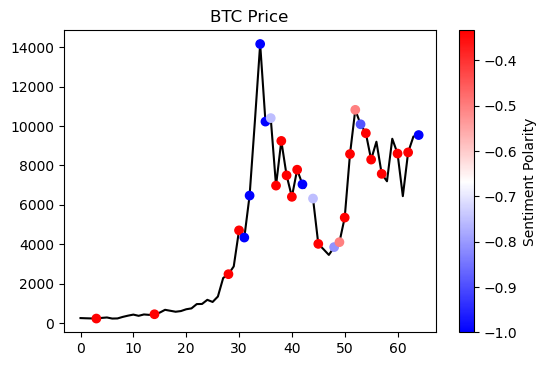

In [206]:
BTC=pd.read_csv('BTC-USD.csv')
p=BTC['Adj Close'].values
num=np.array(num)
plt.plot(p,color='black',zorder=-1)
plt.scatter(np.arange(len(num))[num>0],p[num>0],c=num[num>0],cmap=cm.bwr)
plt.scatter(np.arange(len(num))[num<0],p[num<0],c=num[num<0],cmap=cm.bwr)
plt.title('BTC Price')
cbar = plt.colorbar()
cbar.set_label('Sentiment Polarity')
plt.show()